In [32]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from keras.layers import *



np.set_printoptions(threshold=np.inf)

In [33]:
raw_data = pd.read_csv('../data/train.csv')
raw_data['Temperature'] = raw_data['Temperature'].fillna(raw_data['Temperature'].mean())
raw_data['Humidity'] = raw_data['Humidity'].fillna(raw_data['Humidity'].mean())

            GameId          PlayId  Team      X      Y     S     A   Dis  \
0       2017090700  20170907000118  away  73.91  34.84  1.69  1.13  0.40   
1       2017090700  20170907000118  away  74.67  32.64  0.42  1.35  0.01   
2       2017090700  20170907000118  away  74.00  33.20  1.22  0.59  0.31   
3       2017090700  20170907000118  away  71.46  27.70  0.42  0.54  0.02   
4       2017090700  20170907000118  away  69.32  35.42  1.82  2.43  0.16   
5       2017090700  20170907000118  away  75.06  24.00  1.01  0.32  0.18   
6       2017090700  20170907000118  away  74.11  16.64  1.11  0.83  0.02   
7       2017090700  20170907000118  away  73.37  18.73  1.24  0.74  0.13   
8       2017090700  20170907000118  away  56.63  26.90  0.26  1.86  0.28   
9       2017090700  20170907000118  away  73.35  38.83  4.55  0.76  0.51   
10      2017090700  20170907000118  away  74.15  28.90  0.72  0.73  0.01   
11      2017090700  20170907000118  home  75.82  17.56  2.30  1.39  0.55   
12      2017

In [36]:
def get_time(quarter, clock):
    split_time = clock.split(':')
    return (quarter-1)*15 + int(split_time[0]) + int(split_time[1])/60

def get_distance_to_touchdown(yard_line, possession_team, field_position):
    if possession_team != field_position:
        return yard_line
    else:
        return 100 - yard_line

def get_time_since_snap(time_handoff, time_snap):
    split_handoff = time_handoff.split(':')
    handoff_sec = int(split_handoff[1])*60 + int(split_handoff[2].split('.')[0])
    split_snap = time_handoff.split(':')
    snap_sec = int(split_snap[1])*60 + int(split_snap[2].split('.')[0])
    return float(handoff_sec) - float(snap_sec)

def get_height(player_height):
    split_height = player_height.split('-')
    return int(split_height[0])*12 + int(split_height[1])

def get_age(player_birth_date):
    return 2019 - int(player_birth_date.split('/')[2])

def encode_personnel(personnel):
    PERSONNELS = ['DB', 'DL', 'LB', 'OL', 'QB', 'RB', 'TE', 'WR']
    encoded_personnel = [0]*len(PERSONNELS)
    personnel = personnel.replace(' ','')
    for i in range(0,len(personnel),4):
        encoded_personnel[PERSONNELS.index(personnel[i+1:i+3])] += int(personnel[i])
    return encoded_personnel

def get_offense_features(formation, personnel):
    FORMATIONS = ['SHOTGUN','SINGLEBACK','JUMBO','PISTOL','I_FORM','ACE','WILDCAT','EMPTY']
    one_hot_formation = [int(f == formation) for f in FORMATIONS]
    return one_hot_formation + encode_personnel(personnel)

def get_defense_features(in_the_box, personnel):
    return [in_the_box] + encode_personnel(personnel)

In [37]:
# NEW VERSION (PART A), outputs nn_data, which is everything BUT player distribution
nn_input = []
nn_target = []
for _,play in raw_data.groupby(['PlayId']):
    state_features = []
    state_features.append(get_distance_to_touchdown(play['YardLine'].iloc[0], play['PossessionTeam'].iloc[0], play['FieldPosition'].iloc[0]))
    state_features.append(get_time(play['Quarter'].iloc[0],play['GameClock'].iloc[0]))
    state_features.append(play['Down'].iloc[0])
    state_features.append(play['Distance'].iloc[0])
    state_features.append(get_time_since_snap(play['TimeHandoff'].iloc[0], play['TimeSnap'].iloc[0]))
    offense_features = get_offense_features(play['OffenseFormation'].iloc[0], play['OffensePersonnel'].iloc[0])
    defense_features = get_defense_features(play['DefendersInTheBox'].iloc[0], play['DefensePersonnel'].iloc[0])
    for t,team in play.groupby(['Team']):
        team_features = []
        
        if t == 'home':
            team_features.append(team['HomeScoreBeforePlay'].iloc[0])
            if team['PossessionTeam'].iloc[0] == team['HomeTeamAbbr'].iloc[0]:
                offense_features = offense_features + team_features
            else:
                defense_features = defense_features + team_features
        elif t == 'away':
            team_features.append(team['VisitorScoreBeforePlay'].iloc[0])
            if team['PossessionTeam'].iloc[0] == team['VisitorTeamAbbr'].iloc[0]:
                offense_features = offense_features + team_features
            else:
                defense_features = defense_features + team_features
    print(type(state_features), type(offense_features), type(defense_features))
    print(type(state_features + offense_features + defense_features))
    if np.amax(np.isnan(state_features + offense_features + defense_features)) == 0:
        nn_input.append(state_features + offense_features + defense_features)
        nn_target.append(play['Yards'].iloc[0])

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>


In [38]:
# NEW VERSION PART B, outputs c_nn data, which is just the distribution
c_nn_input = []
c_nn_target = []
for _,play in raw_data.groupby(['PlayId']):
    state_features = []
    offense_features = []
    defense_features = []
    
    for t,team in play.groupby(['Team']):
        team_features = []
        team_features = team_features + list(team['X'])
        team_features = team_features + list(team['Y'])
        team_features = team_features + list(team['A'])
        team_features = team_features + list(team['Dis'])
        team_features = team_features + list(team['Orientation'])
        team_features = team_features + list(team['Dir'])
        #team_features = team_features + list(team['PlayerHeight'].apply(lambda x: get_height(x)))
        team_features = team_features + list(team['PlayerWeight'])
        
        if t == 'home':
            #team_features.append(team['HomeScoreBeforePlay'].iloc[0])
            if team['PossessionTeam'].iloc[0] == team['HomeTeamAbbr'].iloc[0]:
                offense_features = offense_features + team_features
            else:
                defense_features = defense_features + team_features
        elif t == 'away':
            #team_features.append(team['VisitorScoreBeforePlay'].iloc[0])
            if team['PossessionTeam'].iloc[0] == team['VisitorTeamAbbr'].iloc[0]:
                offense_features = offense_features + team_features
            else:
                defense_features = defense_features + team_features
        
    if np.amax(np.isnan(state_features + offense_features + defense_features)) == 0:
        c_nn_input.append(state_features + offense_features + defense_features)
        c_nn_target.append(play['Yards'].iloc[0])

In [43]:
nn_input = np.stack(nn_input)
nn_target = np.array(nn_target)

c_nn_input = np.stack(c_nn_input)
c_nn_target = np.stack(c_nn_target)


In [45]:
print(nn_input.shape)
print(nn_target.shape)
print(type(nn_input))
print(type(nn_target))

print(c_nn_input.shape)
print(c_nn_target.shape)
print(type(c_nn_input))
print(type(c_nn_target))

(23168, 32)
(23168,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(23153, 154)
(23153,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [88]:
input_trn, input_val, target_trn, target_val = train_test_split(nn_input, nn_target, train_size=0.75)
input_ss = StandardScaler()
input_trn = input_ss.fit_transform(input_trn)
input_val = input_ss.transform(input_val)
#target_ss = StandardScaler()
#target_trn = target_ss.fit_transform(target_trn.reshape((-1,1)))
#target_val = target_ss.transform(target_val.reshape((-1,1)))

c_input_trn, c_input_val, c_target_trn, c_target_val = train_test_split(c_nn_input, c_nn_target, train_size=0.75)
input_ss = StandardScaler()
c_input_trn = input_ss.fit_transform(c_input_trn)
c_input_val = input_ss.transform(c_input_val)
#c_target_ss = StandardScaler()
#c_target_trn = target_ss.fit_transform(c_target_trn.reshape((-1,1)))
#c_target_val = target_ss.transform(c_target_val.reshape((-1,1)))

input_trn = np.delete(input_trn, [1,2,3,4,5,6,7,8,9,10,11,12], axis=0)
target_trn = np.delete(target_trn, [1,2,3,4,5,6,7,8,9,10,11,12])

input_val = np.delete(input_val, [1,2,3], axis=0)
target_val = np.delete(target_val, [1,2,3])


# model 1 handles game state
model1 = Sequential()
print(c_input_trn.shape[1:])
model1.add(Dense(units=16, activation='relu', input_shape=(c_input_trn.shape[1:])))
model1.add(Dense(units=8, activation = 'relu'))
model1.add(Dense(units=1))

# model 2 handles "convolution"
model2 = Sequential()
print(input_trn.shape[1:])
model2.add(Dense(units=32, activation='relu', input_shape=(input_trn.shape[1:])))
model2.add(Dense(units=8, activation='relu'))
model2.add(Dense(units=4, activation='relu'))
model2.add(Dense(units=2, activation='relu'))
model2.add(Dense(units=2))

mergedOut = Concatenate()([model1.output,model2.output])
mergedOut = Dense(8, activation = 'relu')(mergedOut)

mergedOut = Dense(1, activation = 'linear')(mergedOut)

from keras.models import Model

newModel = Model([model1.input,model2.input], mergedOut)

newModel.compile(optimizer='adam',loss='mse',metrics=['mse'])

history = newModel.fit(x = [c_input_trn, input_trn], y = target_trn, epochs = 50, verbose = 1, validation_data = ([c_input_val, input_val], target_val)) 
# https://stackoverflow.com/questions/45979848/merge-2-sequential-models-in-keras
# 

yhat = newModel.predict([c_input_val, input_val])

print(mean_squared_error(yhat, target_val))

#callbacks = [EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=False)]

(154,)
(32,)
Train on 17364 samples, validate on 5789 samples
Epoch 1/50
17364/17364 [==============================] - 7s 393us/step - loss: 44.4788 - mean_squared_error: 44.4788 - val_loss: 40.8705 - val_mean_squared_error: 40.8705
Epoch 2/50
17364/17364 [==============================] - 3s 171us/step - loss: 41.5448 - mean_squared_error: 41.5448 - val_loss: 40.4296 - val_mean_squared_error: 40.4296
Epoch 3/50
17364/17364 [==============================] - 3s 169us/step - loss: 40.9205 - mean_squared_error: 40.9205 - val_loss: 40.1368 - val_mean_squared_error: 40.1368
Epoch 4/50
17364/17364 [==============================] - 3s 200us/step - loss: 40.5133 - mean_squared_error: 40.5133 - val_loss: 40.1168 - val_mean_squared_error: 40.1168
Epoch 5/50
17364/17364 [==============================] - 3s 165us/step - loss: 40.1936 - mean_squared_error: 40.1936 - val_loss: 40.2179 - val_mean_squared_error: 40.2179
Epoch 6/50
17364/17364 [==============================] - 3s 166us/step - loss

17364/17364 [==============================] - 3s 154us/step - loss: 21.3494 - mean_squared_error: 21.3494 - val_loss: 55.1207 - val_mean_squared_error: 55.1207
Epoch 49/50
17364/17364 [==============================] - 3s 150us/step - loss: 21.2128 - mean_squared_error: 21.2128 - val_loss: 49.8489 - val_mean_squared_error: 49.8489
Epoch 50/50
17364/17364 [==============================] - 3s 147us/step - loss: 20.7836 - mean_squared_error: 20.7836 - val_loss: 50.4154 - val_mean_squared_error: 50.4154
50.41537972241518


1.093537053852329


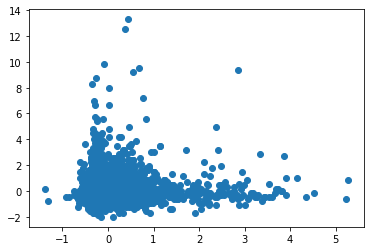

In [84]:
print(np.mean((yhat - target_val)**2))
plt.scatter(yhat, target_val)

In [60]:
history = model.fit(x=input_trn, y=target_trn, epochs=2000, verbose=0, validation_data=(input_val,target_val))

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

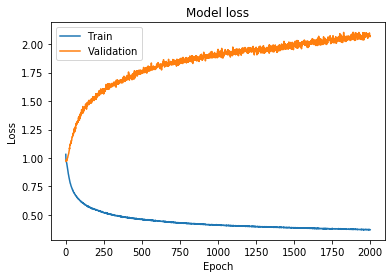